In [ ]:
!pip install git+https://github.com/S-aiueo32/lpips-pytorch.git -q

    Running setup.py install for lpips-pytorch ... done
  DEPRECATION: lpips-pytorch was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
!pip install torch

In [9]:
from lpips_pytorch import LPIPS
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models
import numpy as np
from scipy import linalg
import data
import pylib as py
import module
import torchlib
from tqdm import tqdm
from lpips_pytorch import LPIPS
from matplotlib import pyplot as plt


In [4]:
from torch import nn
from tqdm.auto import trange, tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

import requests
#url = 'https://raw.githubusercontent.com/anastasia-yaschenko/Generative-models/main/celeba%20(1).py'
#open('celeba.py', 'wb').write(requests.get(url).content);
url = 'https://raw.githubusercontent.com/vpozdnyakov/DeepGenerativeModels/spring-2022/data/celeba/list_attr_celeba.txt'
open('list_attr_celeba.txt', 'wb').write(requests.get(url).content);

from celeba import CelebADataset

crop_size = 108

offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop),
    transforms.ToPILImage(),
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = CelebADataset(attr_file_path='list_attr_celeba.txt', transform=transform, crop=False)

data_loader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

shape = (64, 64, 3)

In [129]:
evens = list(range(0, len(dataset), 2))
trainset_1 = torch.utils.data.Subset(dataset, evens)

dataloader = torch.utils.data.DataLoader(trainset_1, batch_size=16, drop_last=True)

In [ ]:
#gan = ['checkpoints_JS/Epoch_(5).ckpt', 'checkpoints_JS/Epoch_(15).ckpt', 'checkpoints_JS/Epoch_(30).ckpt', 'checkpoints_JS/Epoch_(45).ckpt']
#wgan = ['checkpoints_WGAN/Epoch_(5).ckpt', 'checkpoints_WGAN/Epoch_(35).ckpt', 'checkpoints_WGAN/Epoch_(55).ckpt',
'checkpoints_WGAN/Epoch_(80).ckpt'

In [7]:
evens = list(range(0, len(dataset), 2))
trainset_1 = torch.utils.data.Subset(dataset, evens)

lpips = LPIPS().to(device)
dataloader = torch.utils.data.DataLoader(trainset_1, batch_size=64, drop_last=True)

In [ ]:
fake_vs_real = []
fake_grd_vs_real = []
grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook


path_ = 'checkpoints_JS/Epoch_(40).ckpt'
ckpt = torchlib.load_checkpoint(path_)
z_dim = 128
G = module.ConvGenerator(z_dim, 3, n_upsamplings=4).to(device)
D = module.ConvDiscriminator(3, n_downsamplings=4, norm='layer_norm').to(device)
G.load_state_dict(ckpt['G'])
D.load_state_dict(ckpt['D'])
G.eval()
D.eval()

In [77]:

for eta in np.linspace(0, 1, 25):
    count = 0
    fake_vs_real = []
    fake_grd_vs_real = []
    for imgs, _ in dataloader:
        if count >= 4:
            break
        z = torch.randn(64, 128, 1, 1).to(device)
        real_imgs = imgs.to(device)
        fake_imgs = G(z)
        fake_validity = D(fake_imgs)
        g_loss = -torch.mean(fake_validity)
        fake_imgs.register_hook(save_grad('fake_imgs'))
        G.zero_grad()
        g_loss.backward()
        grad_ = grads['fake_imgs']
        
        grads_ = grad_ 
        
        fake_vs_real.append(lpips(fake_imgs, real_imgs).squeeze().item())
        fake_grd_vs_real.append(lpips(fake_imgs - eta*grad_, real_imgs).squeeze().item())

        count += 1
    fake_vs_real = np.array(fake_vs_real)
    fake_grd_vs_real = np.array(fake_grd_vs_real)
    print(f'eta = {np.round(eta, 4)} || LPIPS diff: {np.round(np.mean(np.mean(fake_grd_vs_real) - fake_vs_real), 4)}')
    

eta = 0.0 || LPIPS diff: 0.0
eta = 0.0417 || LPIPS diff: 0.0
eta = 0.0833 || LPIPS diff: 0.0
eta = 0.125 || LPIPS diff: 0.0
eta = 0.1667 || LPIPS diff: 0.0
eta = 0.2083 || LPIPS diff: 0.0
eta = 0.25 || LPIPS diff: -0.0
eta = 0.2917 || LPIPS diff: 0.0
eta = 0.3333 || LPIPS diff: 0.0
eta = 0.375 || LPIPS diff: 0.0001
eta = 0.4167 || LPIPS diff: 0.0
eta = 0.4583 || LPIPS diff: 0.0
eta = 0.5 || LPIPS diff: 0.0001
eta = 0.5417 || LPIPS diff: 0.0
eta = 0.5833 || LPIPS diff: 0.0001
eta = 0.625 || LPIPS diff: 0.0001
eta = 0.6667 || LPIPS diff: 0.0002
eta = 0.7083 || LPIPS diff: 0.0001
eta = 0.75 || LPIPS diff: 0.0001
eta = 0.7917 || LPIPS diff: 0.0
eta = 0.8333 || LPIPS diff: 0.0
eta = 0.875 || LPIPS diff: -0.0
eta = 0.9167 || LPIPS diff: 0.0001
eta = 0.9583 || LPIPS diff: 0.0001
eta = 1.0 || LPIPS diff: 0.0002


In [82]:
path_ = 'checkpoints_JS/Epoch_(40).ckpt'
ckpt = torchlib.load_checkpoint(path_)
z_dim = 128
G = module.ConvGenerator(z_dim, 3, n_upsamplings=4).to(device)
D = module.ConvDiscriminator(3, n_downsamplings=4, norm='layer_norm').to(device)
G.load_state_dict(ckpt['G'])
D.load_state_dict(ckpt['D'])
G.eval()
D.eval()


for imgs, _ in dataloader:
    z = torch.randn(64, 128, 1, 1).to(device)
    real_imgs = imgs.to(device)
    fake_imgs = G(z)
    fake_validity = D(fake_imgs)
    g_loss = -torch.mean(fake_validity)
    fake_imgs.register_hook(save_grad('fake_imgs'))
    G.zero_grad()
    g_loss.backward()
    grad_ = grads['fake_imgs']
    grads_ = grad_
    break

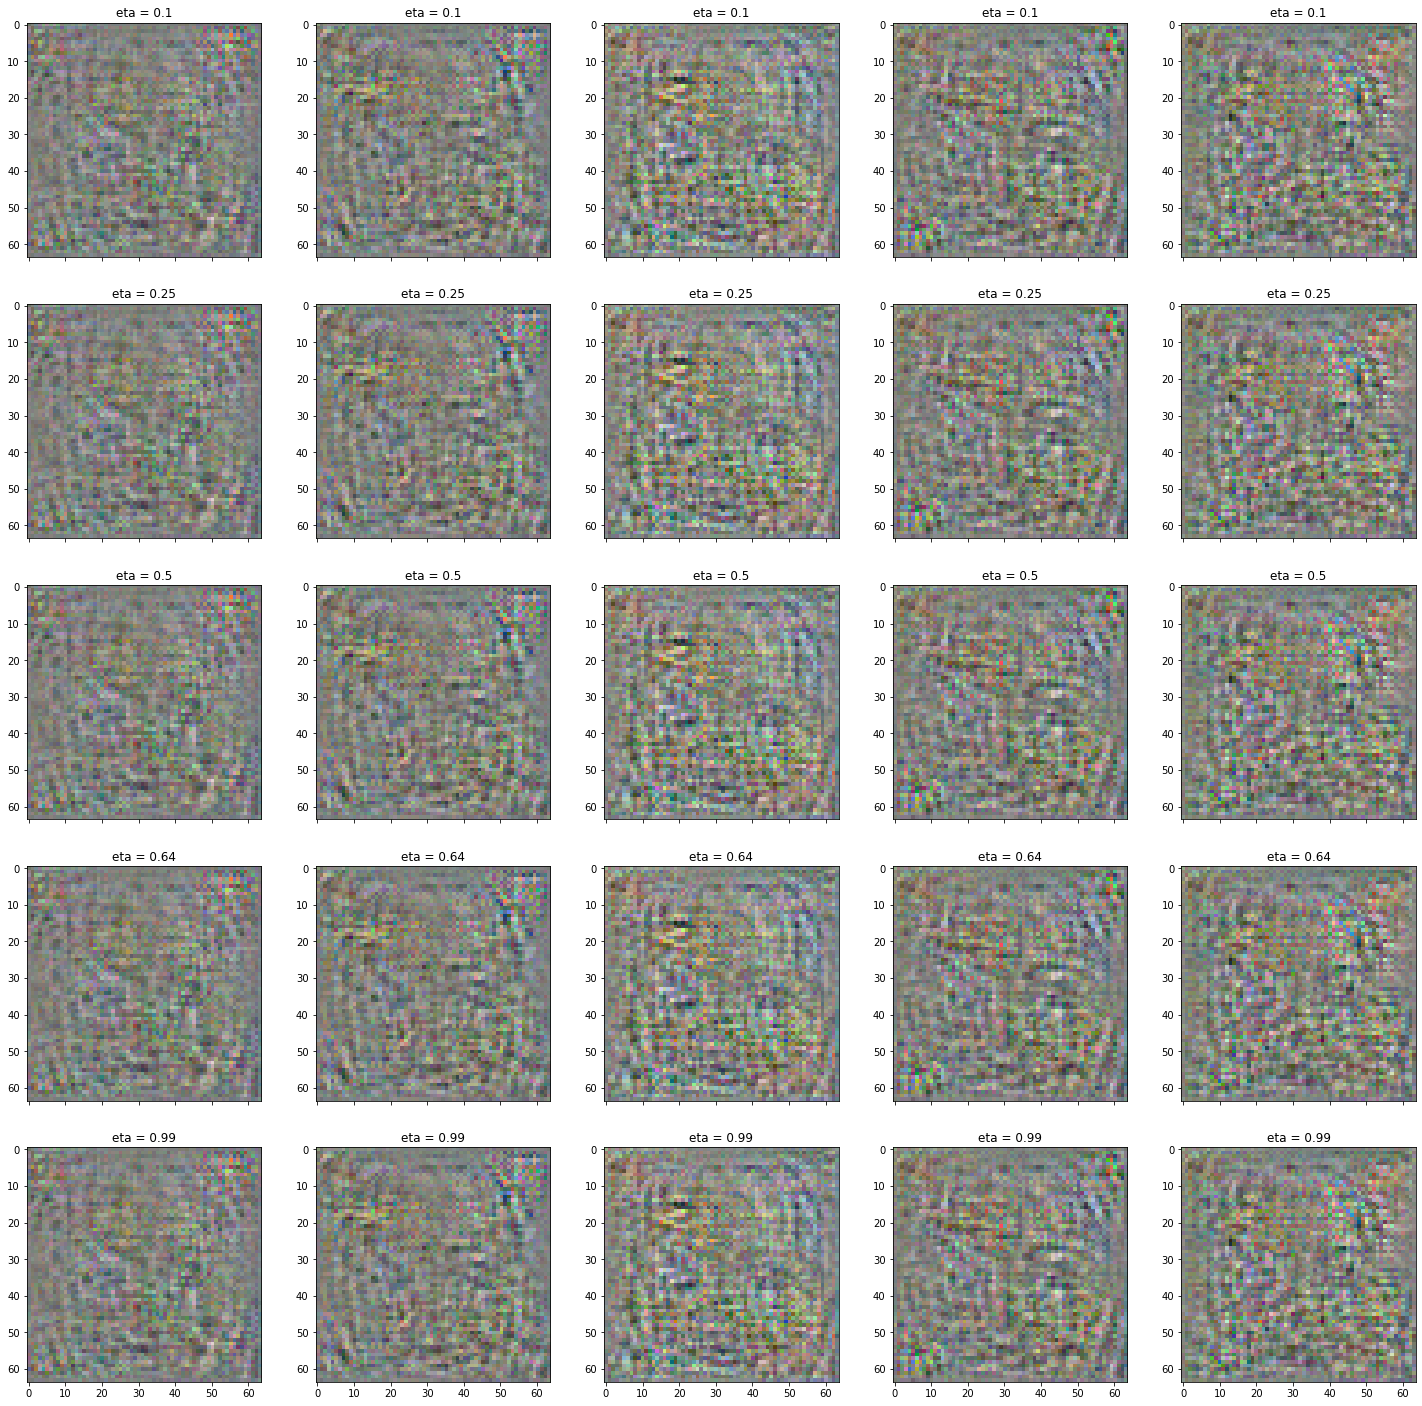

In [83]:
n_ = 5
fig, ax = plt.subplots(n_, 5, sharex=True, figsize=(25, 25))
etas = [0.1, 0.25, 0.5, 0.64, 0.99]
for ind, eta in enumerate(etas):
    for index in range(grad_.shape[0]):
        if index >= 5:
            break
        grad_image = grads_[index].detach().cpu()

        test = (eta*grad_image) + torch.max(torch.abs((eta*grad_image)))
        test = test/test.max()

        ax[ind, index].imshow((test).permute(1, 2, 0))
        ax[ind, index].set_title(f'eta = {np.round(eta, 5)}')
            #plot_img(eta*grad_image, t_invnormalize)
plt.show()



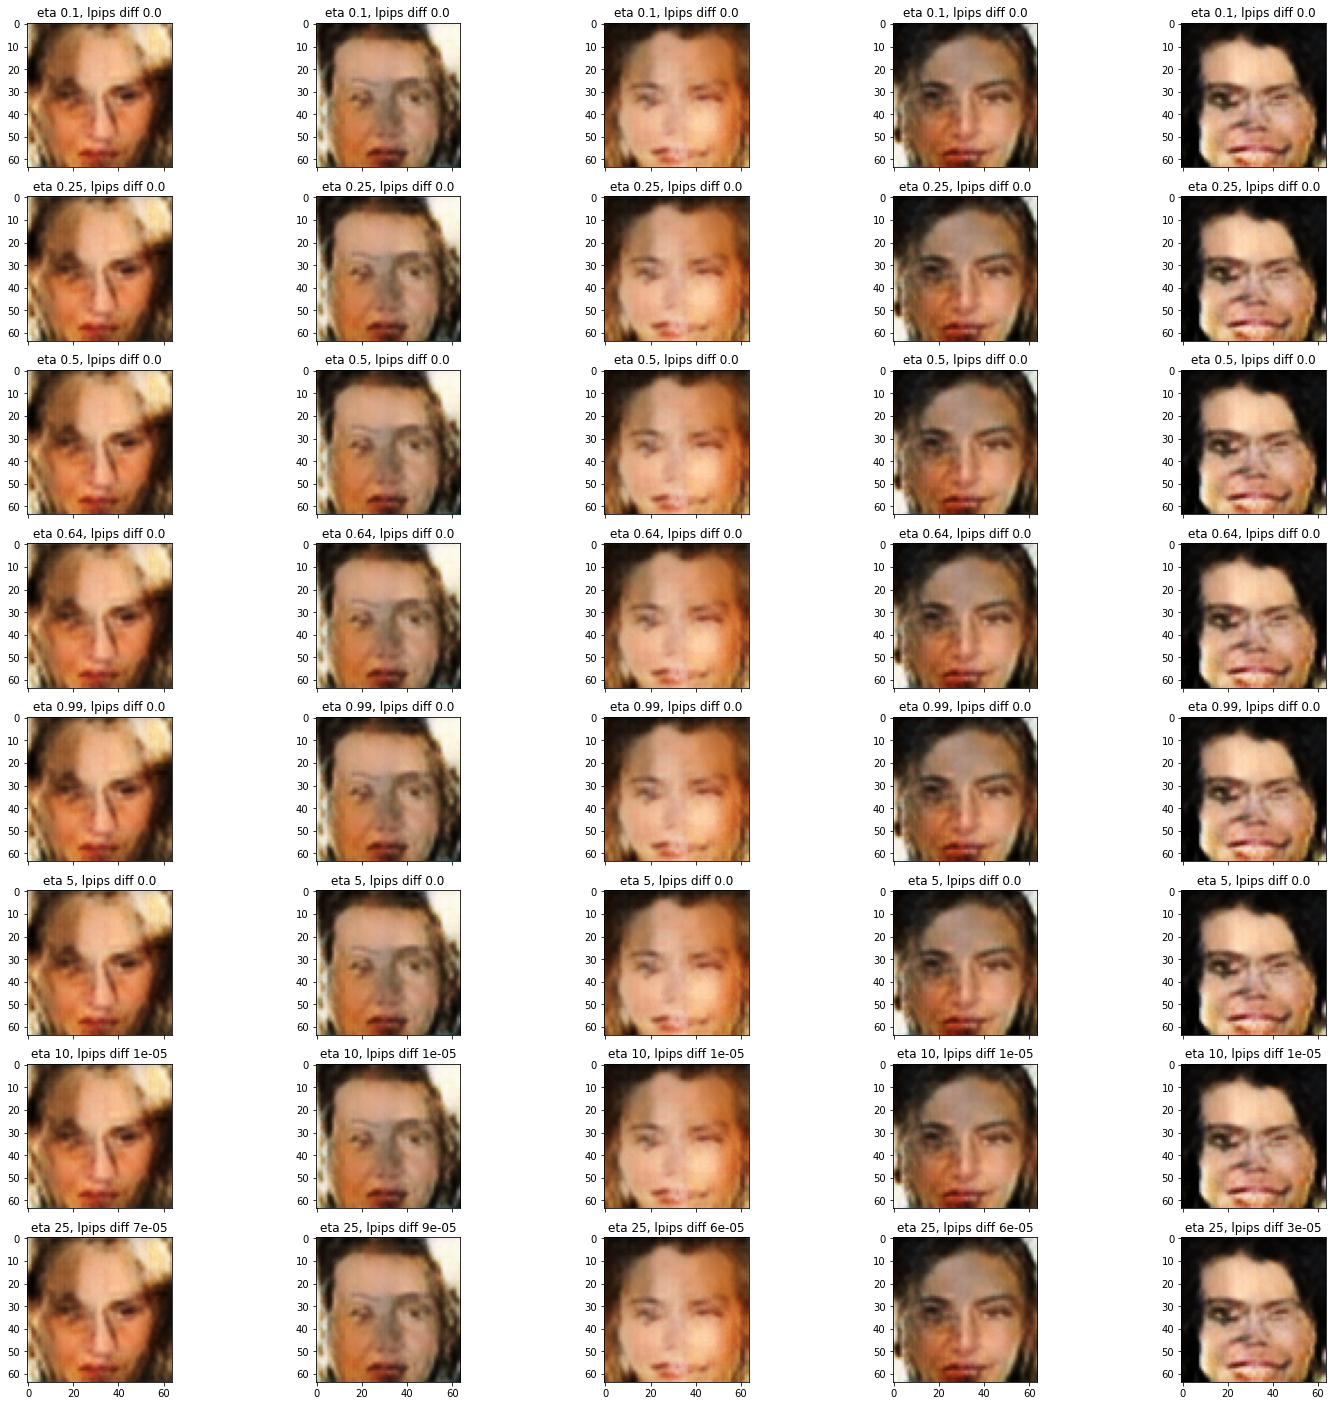

In [86]:
n_ = 8
fig, ax = plt.subplots(n_, 5, sharex=True, figsize=(25, 25))
etas = [0.1, 0.25, 0.5, 0.64, 0.99, 5, 10, 25]
for ind, eta in enumerate(etas):
    for index in range(grad_.shape[0]):
        if index >= 5:
            break
        grad_image = grads_[index].detach().cpu()
        gen_image = fake_imgs[index].detach().cpu()
        real_image = fake_imgs[index].detach().cpu()

        test_real = real_image + torch.max(torch.abs(real_image))
        test_real = (test_real/test_real.max()).to(device).view((1, 3, 64, 64))

        test_fake = gen_image + torch.max(torch.abs(gen_image))
        test_fake = (test_fake/test_fake.max()).to(device).view((1, 3, 64, 64))

        test = (gen_image - eta*grad_image) + torch.max(torch.abs((gen_image - eta*grad_image)))
        test = test/test.max()

        ax[ind, index].imshow((test).permute(1, 2, 0))

        test = test.to(device).view((1, 3, 64, 64))
        ax[ind, index].set_title(f'eta {np.round(eta, 5)}, lpips diff {np.round(lpips(test, test_real).squeeze().item() - lpips(test_fake, test_real).squeeze().item(), 5)}')
        #ax[ind, index].imshow(((gen_image - eta*grad_image)/(gen_image - eta*grad_image).max() + 1).permute(1, 2, 0))
            #plot_img(eta*grad_image, t_invnormalize)
plt.show()

